14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9405/9405 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Original prediction: ('n02077923', 'sea_lion', np.float32(0.98555183))
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Adversarial prediction: ('n04251144', 'snorkel', np.float32(0.16597527))


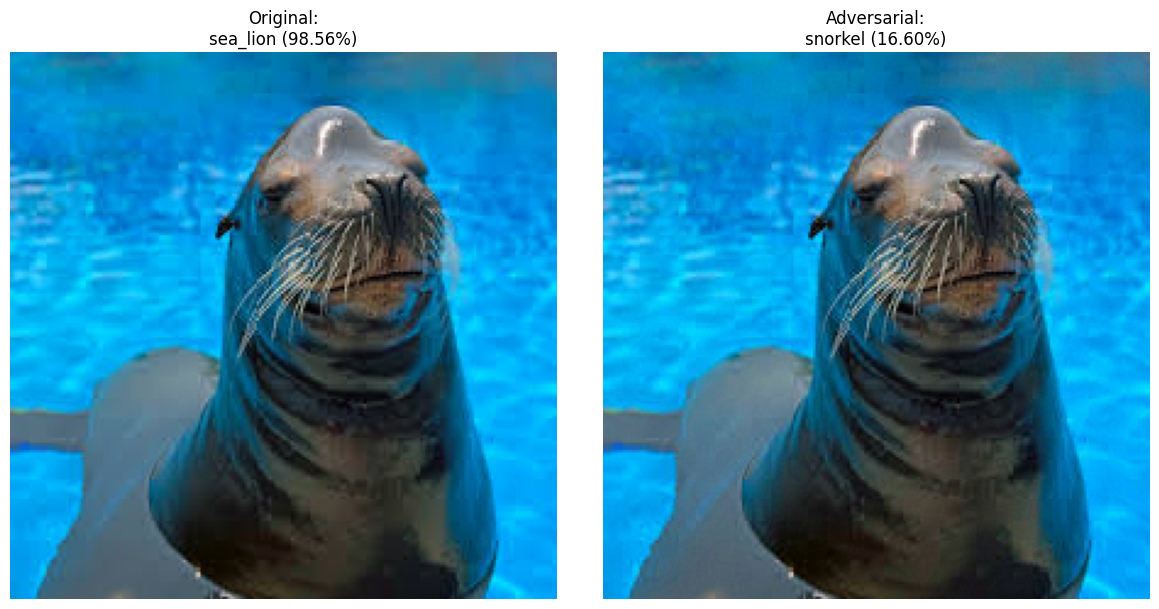

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib as mpl
import keras

# ======= Load pre-trained CNN (MobileNetV2) =======
model = tf.keras.applications.MobileNetV2(weights='imagenet')
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

# ======= Load and preprocess an image =======
img_path = tf.keras.utils.get_file('elephant.jpg', 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRx5RY3qhvZyAoKyi3Es0b3jDooeNP4sFB1iQ&s')
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_array)

img_tensor = tf.convert_to_tensor(img_preprocessed)

# ======= Predict original =======
preds = model.predict(img_tensor)
decoded = decode_predictions(preds, top=1)[0][0]
print(f"Original prediction: {decoded}")

# ======= FGSM Adversarial Attack =======
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
label = tf.one_hot(np.argmax(preds), preds.shape[-1])
label = tf.reshape(label, (1, preds.shape[-1]))  # Ensure shape matches predictions

epsilon = 0.01

with tf.GradientTape() as tape:
    tape.watch(img_tensor)
    prediction = model(img_tensor)
    loss = loss_object(label, prediction)

gradient = tape.gradient(loss, img_tensor)
signed_grad = tf.sign(gradient)

adv_image = img_tensor + epsilon * signed_grad
adv_image = tf.clip_by_value(adv_image, -1, 1)

adv_preds = model.predict(adv_image)
decoded_adv = decode_predictions(adv_preds, top=1)[0][0]
print(f"Adversarial prediction: {decoded_adv}")

# ======= Visualize original and adversarial =======
def deprocess_image(img):
    img = img[0]
    img = (img + 1) * 127.5  # Rescale [-1,1] to [0,255]
    return np.clip(img, 0, 255).astype(np.uint8)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title(f"Original:\n{decoded[1]} ({decoded[2]*100:.2f}%)")
plt.imshow(deprocess_image(img_tensor.numpy()))
plt.axis("off")

plt.subplot(1,2,2)
plt.title(f"Adversarial:\n{decoded_adv[1]} ({decoded_adv[2]*100:.2f}%)")
plt.imshow(deprocess_image(adv_image.numpy()))
plt.axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Adversarial prediction (Gaussian noise): ('n02077923', 'sea_lion', np.float32(0.9917579))


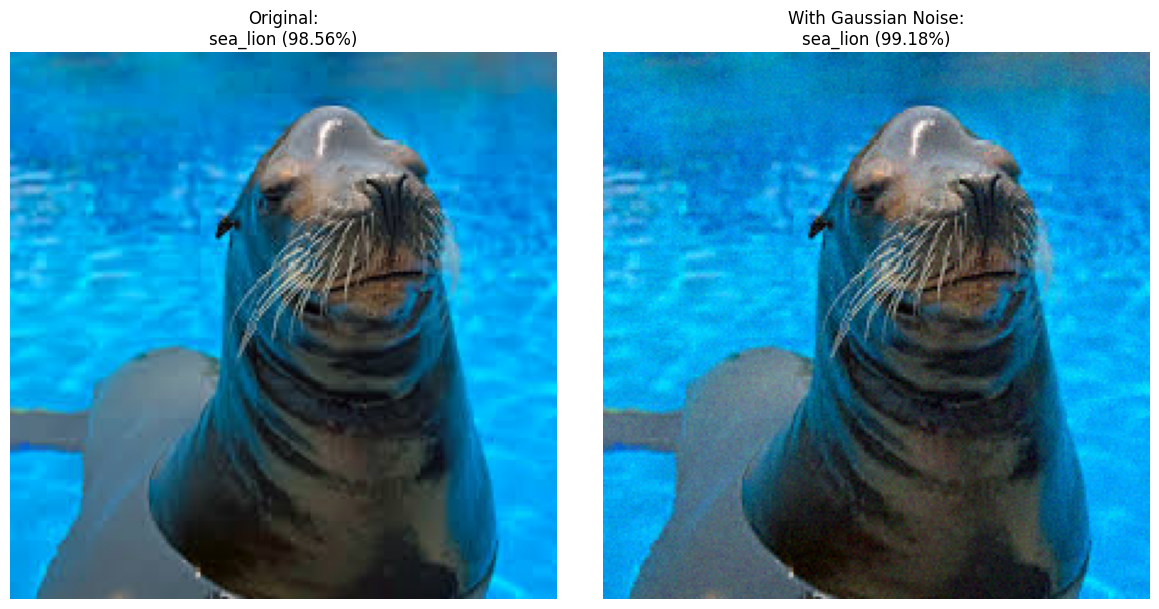

In [ ]:
# ======= Gaussian Noise Attack =======
mean = 0.0
stddev = 0.05  # You can increase this value to add more noise
gaussian_noise = tf.random.normal(shape=img_tensor.shape, mean=mean, stddev=stddev, dtype=tf.float32)

adv_image = img_tensor + gaussian_noise
adv_image = tf.clip_by_value(adv_image, -1, 1)

adv_preds = model.predict(adv_image)
decoded_adv = decode_predictions(adv_preds, top=1)[0][0]
print(f"Adversarial prediction (Gaussian noise): {decoded_adv}")

# ======= Visualize original and adversarial =======
def deprocess_image(img):
    img = img[0]
    img = (img + 1) * 127.5
    return np.clip(img, 0, 255).astype(np.uint8)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title(f"Original:\n{decoded[1]} ({decoded[2]*100:.2f}%)")
plt.imshow(deprocess_image(img_tensor.numpy()))
plt.axis("off")

plt.subplot(1,2,2)
plt.title(f"With Gaussian Noise:\n{decoded_adv[1]} ({decoded_adv[2]*100:.2f}%)")
plt.imshow(deprocess_image(adv_image.numpy()))
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
last_conv_layer_name="Conv_1"

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted: [('n02077923', 'sea_lion', np.float32(0.98555183))]


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


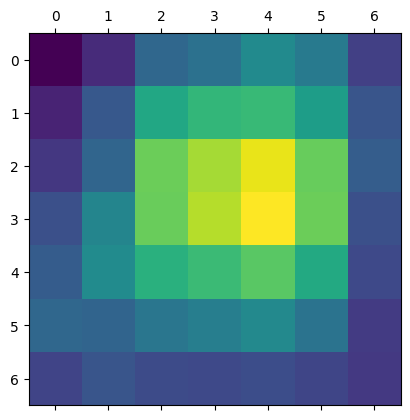

In [ ]:
# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


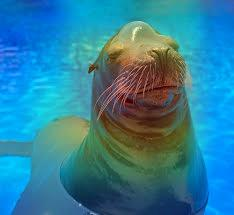

In [ ]:

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from IPython.display import Image, display
import cv2

# Load model
model = MobileNetV2(weights='imagenet')
last_conv_layer_name = "Conv_1"

# Load image
img_path = tf.keras.utils.get_file('elephant.jpg', 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRx5RY3qhvZyAoKyi3Es0b3jDooeNP4sFB1iQ&s')
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_array)

img_tensor = tf.convert_to_tensor(img_preprocessed)


# Prediction
preds = model.predict(img_tensor)
pred_label = np.argmax(preds)
decoded = decode_predictions(preds, top=1)[0][0]
print(f"Original prediction: {decoded}")

# ======= FGSM Adversarial Attack =======
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
label = tf.one_hot(np.argmax(preds), preds.shape[-1])
label = tf.reshape(label, (1, preds.shape[-1]))  # Ensure shape matches predictions

epsilon = 0.01

with tf.GradientTape() as tape:
    tape.watch(img_tensor)
    prediction = model(img_tensor)
    loss = loss_object(label, prediction)

gradient = tape.gradient(loss, img_tensor)
signed_grad = tf.sign(gradient)

adv_image = img_tensor + epsilon * signed_grad
adv_image = tf.clip_by_value(adv_image, -1, 1)

adv_preds = model.predict(adv_image)
decoded_adv = decode_predictions(adv_preds, top=1)[0][0]
print(f"Adversarial prediction: {decoded_adv}")
adv_label = np.argmax(adv_preds)


# ========== Grad-CAM ==========
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def overlay_heatmap(img, heatmap, alpha=0.4):
    import matplotlib.cm as cm
    img = keras.utils.img_to_array(img)

    # Normalize heatmap and convert to colormap
    heatmap = np.uint8(255 * heatmap)

    jet = mpl.colormaps["jet"]
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    return superimposed_img




# Generate Grad-CAM heatmaps
heatmap_original = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
heatmap_adversarial = make_gradcam_heatmap(adv_image.numpy(), model, last_conv_layer_name)

# ========== Integrated Gradients ==========
def integrated_gradients(model, baseline, input_img, target_class_idx, steps=50):
    input_img = tf.cast(tf.squeeze(input_img, axis=0), tf.float32)
    baseline = tf.cast(tf.squeeze(baseline, axis=0), tf.float32)

    # Generate interpolated images
    interpolated_imgs = [baseline + (i / steps) * (input_img - baseline) for i in range(steps + 1)]
    interpolated_imgs = tf.stack(interpolated_imgs)

    with tf.GradientTape() as tape:
        tape.watch(interpolated_imgs)
        predictions = model(interpolated_imgs)
        probs = predictions[:, target_class_idx]

    grads = tape.gradient(probs, interpolated_imgs)
    avg_grads = tf.reduce_mean(grads, axis=0)  # shape: (H, W, C)
    ig = (input_img - baseline) * avg_grads
    saliency = tf.reduce_sum(tf.math.abs(ig), axis=-1).numpy()  # shape: (H, W)

    # Normalize
    saliency = saliency / (np.max(saliency) + 1e-8)
    return saliency


baseline = tf.zeros_like(img_tensor)

ig_orig = integrated_gradients(model, baseline, img_tensor, pred_label)
ig_adv = integrated_gradients(model, baseline, adv_image, adv_label)


def plot_ig_overlay(input_img, ig_map, title="IG Saliency", alpha=0.6):
    img = tf.squeeze(input_img).numpy()
    img = (img + 1) * 127.5  # Rescale from [-1, 1] to [0, 255]
    img = np.clip(img, 0, 255).astype(np.uint8)

    plt.imshow(img)
    plt.imshow(ig_map, cmap='inferno', alpha=alpha)
    plt.colorbar(fraction=0.04, pad=0.04)
    plt.title(title)
    plt.axis("off")

# ========== Plot all 3x2 ==========

plt.figure(figsize=(12, 10))
def deprocess_image(img):
    img = img[0]
    img = (img + 1) * 127.5
    return np.clip(img, 0, 255).astype(np.uint8)

img_adv=deprocess_image(adv_image.numpy())
plt.subplot(2,3,1)
plt.title(f"Original:\n{decoded[1]} ({decoded[2]*100:.2f}%)")
plt.imshow(deprocess_image(img_tensor.numpy()))
plt.axis("off")

plt.subplot(2,3,2)
plt.title(f"With Gaussian Noise:\n{decoded_adv[1]} ({decoded_adv[2]*100:.2f}%)")
plt.imshow(deprocess_image(adv_image.numpy()))
plt.axis("off")
# Grad-CAM original
plt.subplot(2,3, 3)
plt.title("Grad-CAM (Original)")
plt.imshow(overlay_heatmap(img, heatmap_original))
plt.axis('off')

# Grad-CAM adversarial
plt.subplot(2,3, 4)
plt.title("Grad-CAM (Adversarial)")
plt.imshow(overlay_heatmap(img_adv, heatmap_adversarial))
plt.axis('off')

# IG original
plt.subplot(2,3, 5)
plot_ig_overlay(img_tensor, ig_orig, title="IG (Original Image)")
plt.axis('off')

# IG adversarial
plt.subplot(2,3, 6)
plot_ig_overlay(adv_image, ig_adv, title="IG (Adversarial Image)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:

from tensorflow.keras.models import Model
img_size = (224, 224)
# Step 2: Predict to get class index
preds = model.predict(img_preprocessed)
class_index = np.argmax(preds[0])
print("Predicted:", decode_predictions(preds, top=1)[0])

def gradcam_with_softmax(model, image_tensor, class_index, last_conv_layer_name="Conv_1"):
    # Build model that outputs both last conv layer and softmax
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = Model(inputs=model.inputs,
                       outputs=[last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_output, softmax_output = grad_model(image_tensor)
        class_output = softmax_output[:, class_index]  # Use softmax output here

    # Compute gradients
    grads = tape.gradient(class_output, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output[0]), axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], img_size).numpy()
    return heatmap[..., 0]

# Overlay heatmap
def overlay_heatmap(heatmap, img, alpha=0.4):
    img = keras.utils.img_to_array(img)

    # Normalize heatmap and convert to colormap
    heatmap = np.uint8(255 * heatmap)

    jet = mpl.colormaps["jet"]
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    return superimposed_img

# Generate Grad-CAMs
heatmap_softmax = gradcam_with_softmax(model, img_preprocessed, class_index)



# Step 3: Integrated Gradients using pre-softmax (logits)
def compute_integrated_gradients(model, input_tensor, class_index, baseline=None, steps=50):
    if baseline is None:
        baseline = tf.zeros_like(input_tensor)

    # Linear interpolation between baseline and input
    interpolated_inputs = [baseline + (i / steps) * (input_tensor - baseline) for i in range(steps + 1)]
    interpolated_inputs = tf.convert_to_tensor(np.concatenate(interpolated_inputs, axis=0))

    # Use logits (pre-softmax)
    with tf.GradientTape() as tape:
        tape.watch(interpolated_inputs)
        logits = model(interpolated_inputs)
        target_logits = logits[:, class_index]

    grads = tape.gradient(target_logits, interpolated_inputs)  # [steps+1, H, W, C]
    avg_grads = tf.reduce_mean(grads, axis=0)  # [H, W, C]

    integrated_grads = (input_tensor - baseline)[0] * avg_grads  # [H, W, C]
    return integrated_grads.numpy()

# Step 4: Compute IG
attributions = compute_integrated_gradients(model, img_preprocessed, class_index)

# Step 5: Visualize
def plot_integrated_gradients(attributions):
    attributions = np.sum(np.abs(attributions), axis=-1)  # [H, W]
    attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min() + 1e-8)

    plt.title("Integrated Gradients (Logits)")
    plt.imshow(attributions, cmap='inferno')
    plt.axis('off')

# Plot both Grad-CAMs
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Grad-CAM (Softmax)")
plt.imshow(overlay_heatmap(heatmap_softmax, img))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("IG (Pre Softmax)")
plot_integrated_gradients(attributions)
plt.axis("off")
plt.show()